In [131]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_svmlight_file
import numpy as np
import pickle
import glob
import os

from matplotlib.ticker import MaxNLocator

from utils import unpickle_dir

LOG_SCALE = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
# need to install Latex (msttcorefonts and texlive packages)
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [134]:
baselines = unpickle_dir('../results/baselines')['baselines']
baselines

{'RCV1-test': 0.0847738033860771, 'epsilon': 0.28241561280203953}

/home/cordonni/.conda/envs/sparsifiedSGD/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/cordonni/.conda/envs/sparsifiedSGD/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


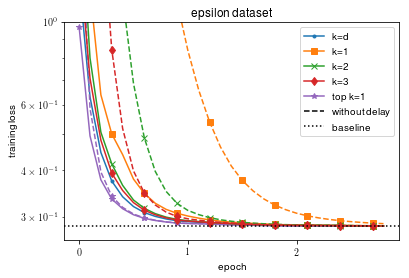

In [135]:
def plot_epsilon(ax):
    data = unpickle_dir('../results/eps-th')

    markers_every = 3
    show = {
        "full-sgd-no-shift": ("C0.--", None),
        "full-sgd-no-shift": ("C0.-", None),
        "rand1-d": ("C1s-", "k=1"),
        "rand1-no-shift": ("C1s--", None),
        "rand2-d/k": ("C2x-", "k=2"),
        "rand2-no-shift": ("C2x--", None),
        "rand3-d/k": ("C3d-", "k=3"),
        "rand3-no-shift": ("C3d--", None),
        "top1": ("C4*-", None),
        "top1-no-shift": ("C4*--", None),
    }
    ax.plot([], [], 'C0.-', label='k=d')

    for p, loss in zip(data['params'], map(lambda x: x[1], data['results'])):
        loss =loss[1:-1]
        if p.name in show:
            style, label = show[p.name]
            ax.plot(np.arange(len(loss)) / 10, loss, style, label=label, markevery=markers_every)

    ax.plot([], [], 'C4*-', label='top k=1')
    ax.plot([], [], color='black', linestyle='--', label="without delay")
    ax.axhline(baselines['epsilon'], color='black', linestyle=':', label='baseline')
    ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim([0.26, 1.]);
    ax.set_title('epsilon dataset');
    ax.set_xlabel('epoch');
    ax.set_ylabel('training loss');
    if LOG_SCALE:
        ax.set_yscale("log")

fig, ax = plt.subplots(1)
plot_epsilon(ax)

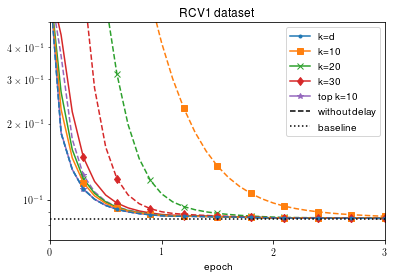

In [136]:
def plot_rcv1(ax):
    data = unpickle_dir('../results/rcv-th')

    markers_every = 3
    show = {
        "full-sgd": ("C0.--", None),
        "rand10": ("C3d-", None),
        "rand10-no-shift": ("C1s--", None),
        "rand20": ("C2x-", None),
        "rand20-no-shift": ("C2x--", None),
        "rand30": ("C1s-", None),
        "rand30-no-shift": ("C3d--", None),
        "top10": ("C4*-", "top k=10"),
        "top10-no-shift": ("C4*--", None),
    }
    
    ax.plot([],[],'C0.-',label='k=d')
    ax.plot([],[],'C1s-',label='k=10')
    ax.plot([],[],'C2x-',label='k=20')
    ax.plot([],[],'C3d-',label='k=30')

    for p, loss in zip(data['params'], map(lambda x: x[1], data['results'])):
        loss =loss[:-1] 
        if p.name in show:
            style, label = show[p.name]
            ax.plot(np.arange(len(loss)) / 10, loss, style, label=label, markevery=markers_every)
            
    # reprint blue on top
    p, loss = list(zip(data['params'], map(lambda x: x[1], data['results'])))[0]
    loss =loss[:-1] 
    style, label = show[p.name]
    ax.plot(np.arange(len(loss)) / 10, loss, style, label=label, markevery=markers_every)

    ax.plot([], [], color='black', linestyle='--', label="without delay")
    ax.axhline(baselines['RCV1-test'], color='black', linestyle=':', label='baseline')
    ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(0.07, .5);
    ax.set_xlim(0., 3.);
    ax.set_title('RCV1 dataset');
    ax.set_xlabel('epoch');
#     ax.set_ylabel('training loss');
    if LOG_SCALE:
        ax.set_yscale("log")

fig, ax = plt.subplots(1)
plot_rcv1(ax)

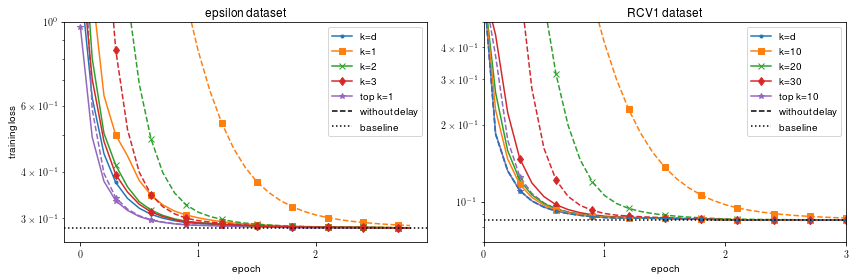

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax1, ax2 = axes

plot_epsilon(ax1)
plot_rcv1(ax2)
plt.tight_layout()
fig.savefig('../figures/theory.pdf')

# Compare QSGD

In [138]:
def qsgd_bits_used(precision, d, d_eff=None, with_method=False):
    """
    precision: bits used by QSGD
    d: dimension of the vectors
    d_eff: d * average density (only for sparse datasets)
    with_method: if True, return the method used
    """
    s = 2 ** precision
    alternatives = []
    bits = []
    
    # naive encoding
    alternatives.append('naive')
    bits.append((precision + 1) * d)
    
    # bound in QSGD with Elias coding
    alternatives.append('QSGD elias boud')
    bits.append(3 * s * (s + np.sqrt(d)) + 32)
    
    # for sparse vectors send indices and values
    if d_eff:
        bits_to_encode_indices = 2 ** np.log2(np.log2(d))
        alternatives.append('sparse with indices')
        bits.append((precision + 1 + 32) * d_eff)
    
    bits = np.ceil(np.array(bits))
    best_idx = bits.argmin()
    
    if with_method:
        return int(bits[best_idx]), alternatives[best_idx]
    else:
        return int(bits[best_idx])

for name, d, d_eff in [('rcv', 47236, 70), ('epsilon', 2000, None)]:
    for b in [2, 4, 8]:
        bits, method = qsgd_bits_used(b, d, d_eff, with_method=True)
        print("QSGD {}-bits on {}: {} bits per gradient sent computed using {}".format(b, name, bits, method))

QSGD 2-bits on rcv: 2450 bits per gradient sent computed using sparse with indices
QSGD 4-bits on rcv: 2590 bits per gradient sent computed using sparse with indices
QSGD 8-bits on rcv: 2870 bits per gradient sent computed using sparse with indices
QSGD 2-bits on epsilon: 617 bits per gradient sent computed using QSGD elias boud
QSGD 4-bits on epsilon: 2947 bits per gradient sent computed using QSGD elias boud
QSGD 8-bits on epsilon: 18000 bits per gradient sent computed using naive


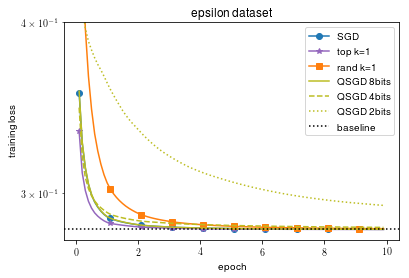

In [139]:
eps_ylim = [baselines['epsilon'] - 0.005, .4]

def plot_qsgd_epsilon(ax):
    baseline = baselines['epsilon']
    data = unpickle_dir('../results/eps-quantized')

    markers_every = 10
    show = {
        "full-sgd": ("C0-o", "SGD"),
        "qsgd-8bit": ("C8-", "QSGD 8bits"),
        "qsgd-4bit": ("C8--", "QSGD 4bits"),
        "qsgd-2bit": ("C8:", "QSGD 2bits"),
        "top1": ("C4*-", "top k=1"),
        "rand1": ("C1s-", "rand k=1"),
    }

    for p, loss in zip(data['params'], map(lambda x: x[1], data['results'])):
        loss =loss[1:-1]
        if p.name in show:
            style, label = show[p.name]
            ax.plot(np.arange(1, len(loss) + 1) / 10, loss, style, label=label, markevery=markers_every)
    ax.axhline(baseline, color='black', linestyle=':', label='baseline')
    ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(eps_ylim);
    ax.set_title('epsilon dataset');
    ax.set_xlabel('epoch');
    ax.set_ylabel('training loss');
    if LOG_SCALE:
        ax.set_yscale("log")
    
fig, ax = plt.subplots(1)
plot_qsgd_epsilon(ax)

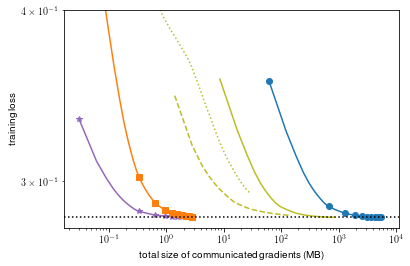

In [140]:
def plot_qsgd_epsilon_com(ax):
    baseline = baselines['epsilon']
    data = unpickle_dir('../results/eps-quantized')
    num_samples = 400000
    one_mb = 8 * (2 ** 20)
    d = 2000

    markers_every = 10
    show = {
        "full-sgd": ("C0-o", "SGD", 32 * 2 * d),
        "qsgd-2bit": ("C8:", "QSGD 2bits", qsgd_bits_used(2, d)),
        "qsgd-4bit": ("C8--", "QSGD 4bits", qsgd_bits_used(4, d)),
        "qsgd-8bit": ("C8-", "QSGD 8bits", qsgd_bits_used(8, d)), 
        "top1": ("C4*-", "top k=1", 2 * 32),
        "rand1": ("C1s-", "rand k=1", 2 * 32),       
    }

    for p, loss in zip(data['params'], map(lambda x: x[1], data['results'])):
        loss =loss[1:-1]
        if p.name in show:
            style, label, bits_per_update = show[p.name]
            ax.plot(np.arange(1, len(loss) + 1) / 100 * num_samples * bits_per_update / one_mb, loss, style, label=label, markevery=markers_every)
    ax.axhline(baseline, color='black', linestyle=':', label='baseline')
#     ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(eps_ylim);
#     ax.set_title('epsilon dataset');
    ax.set_xlabel('total size of communicated gradients (MB)');
    ax.set_ylabel('training loss');
    ax.set_xscale("log")
    if LOG_SCALE:
        ax.set_yscale("log")
    
fig, ax = plt.subplots(1)
plot_qsgd_epsilon_com(ax)

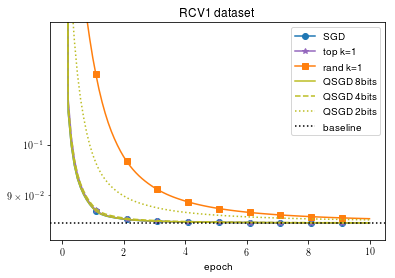

In [141]:
rcv_ylim = [baselines['RCV1-test'] - 0.003, .13]

def plot_qsgd_rcv1(ax):
    baseline = baselines['RCV1-test']
    data = unpickle_dir('../results/rcv-quantized')

    markers_every = 10
    show = {
        "full-sgd": ("C0-o", "SGD"),
        "qsgd-8bit": ("C8-", "QSGD 8bits"),
        "qsgd-4bit": ("C8--", "QSGD 4bits"),
        "qsgd-2bit": ("C8:", "QSGD 2bits"),
        "top1": ("C4*-", "top k=1"),
#         "rand10": ("C68-", "rand k=10"),
        "rand1": ("C1s-", "rand k=1"),
    }

    for p, loss in zip(data['params'], map(lambda x: x[1], data['results'])):
        loss =loss[:-1]
        if p.name in show:
            style, label = show[p.name]
            ax.plot(np.arange(1, len(loss) + 1) / 10, loss, style, label=label, markevery=markers_every)
    ax.axhline(baseline, color='black', linestyle=':', label='baseline')
    ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(rcv_ylim);
    # ax.set_xlim([0, 1.]);
    ax.set_title('RCV1 dataset');
    ax.set_xlabel('epoch');
#     ax.set_ylabel('training loss');
    if LOG_SCALE:
        ax.set_yscale("log")
    
fig, ax = plt.subplots(1)
plot_qsgd_rcv1(ax)

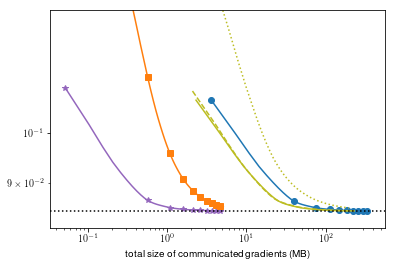

In [142]:

def plot_qsgd_rcv1_com(ax):
    baseline = baselines['RCV1-test']
    data = unpickle_dir('../results/rcv-quantized')

    num_samples = 677399
    d = 47236
    d_eff = 70
    one_mb = 8 * (2 ** 20)

    markers_every = 10
    show = {
        "full-sgd": ("C0-o", "SGD", 32 * 2 * d_eff),
        "qsgd-2bit": ("C8:", "QSGD 2bits", qsgd_bits_used(2, d, d_eff)),
        "qsgd-4bit": ("C8--", "QSGD 4bits", qsgd_bits_used(4, d, d_eff)),
        "qsgd-8bit": ("C8-", "QSGD 8bits", qsgd_bits_used(8, d, d_eff)),
        "top1": ("C4*-", "top k=1", 1 * 2 * 32),
        "rand1": ("C1s-", "rand k=1", 1 * 2 * 32),
    }

    for p, loss in zip(data['params'], map(lambda x: x[1], data['results'])):
        loss =loss[1:-1]
        if p.name in show:
            
            style, label, bits_per_update = show[p.name]
            ax.plot(np.arange(1, len(loss) + 1) / 100 * num_samples * bits_per_update / one_mb, loss, style, label=label, markevery=markers_every)
    ax.axhline(baseline, color='black', linestyle=':', label='baseline')
#     ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(rcv_ylim);
    # ax.set_xlim([0, 1.]);
#     ax.set_title('RCV1 dataset');
    ax.set_xlabel('total size of communicated gradients (MB)');
#     ax.set_ylabel('training loss');

    ax.set_xscale("log")
    if LOG_SCALE:
        ax.set_yscale("log")
    
fig, ax = plt.subplots(1)
plot_qsgd_rcv1_com(ax)

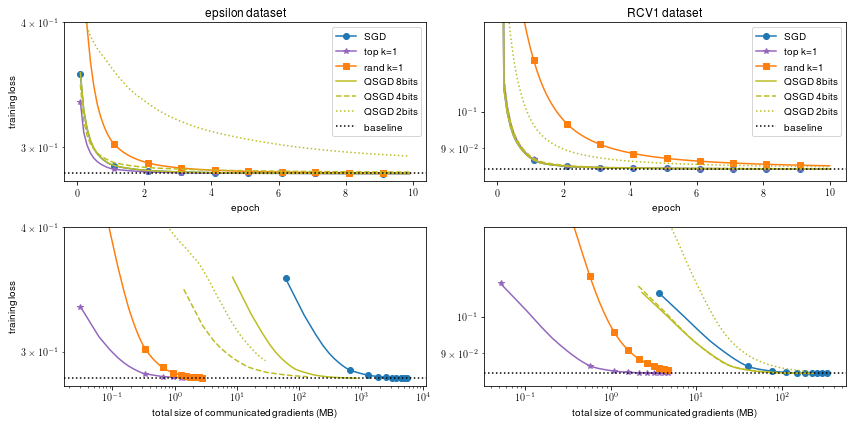

In [143]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
[ax1, ax2], [ax3, ax4] = axes

plot_qsgd_epsilon(ax1)
plot_qsgd_rcv1(ax2)
plot_qsgd_epsilon_com(ax3)
plot_qsgd_rcv1_com(ax4)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.3)
plt.tight_layout()
fig.savefig('../figures/qsgd.pdf')

# Speed up multi core

In [29]:
def compute_speed_up(chronos):
    chs = np.median(chronos, axis=-1)
#     chs = data['chronos'][...,0]
    return np.expand_dims(chs[:,0], -1) / chs

In [30]:
def compute_speedup_margin(chronos):
    refs = np.nanmin(chronos[:,0,:], axis=-1)
    return refs[:, np.newaxis, np.newaxis] / np.sort(chronos, axis=-1)

In [31]:
def merge_data(*datas):
    assert len(datas) > 0
    for d1, d2 in zip(datas, datas[1:]):
        assert [m.name for m in d1['models']] == [m.name for m in d2['models']]

    models = datas[0]['models']
    all_cores = sorted(list(set(c for d in datas for c in d['cores'])))
    max_repeat = sum(d['chronos'].shape[-1] for d in datas)

    res = {
        'cores': all_cores,
        'models': models,
        'chronos': np.zeros((len(models), len(all_cores), max_repeat)),
        'stop_times': np.zeros((len(models), len(all_cores), max_repeat), dtype=int),
    }

    for model_idx, model in enumerate(models):
        cum_repeat = 0
        for data_idx, data in enumerate(datas):
            for core_idx, core in enumerate(data['cores']):
                res_core_idx = all_cores.index(core)
                for data_repeat in range(data['chronos'].shape[-1]):
                    res['chronos'][model_idx, res_core_idx, cum_repeat + data_repeat] = data['chronos'][model_idx, core_idx, data_repeat]
                    res['stop_times'][model_idx, res_core_idx, cum_repeat + data_repeat] = data['stop_times'][model_idx, core_idx, data_repeat]


            cum_repeat += data['chronos'].shape[-1]
    
    res['chronos'][res['chronos'] == 0] = np.nan
    return res

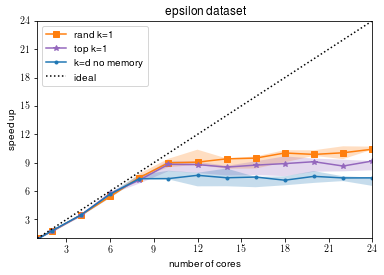

In [32]:
def speedup_epsilon(ax):
    data = unpickle_dir("../results/epsilon-par")
    speed_ups = compute_speedup_margin(data['chronos'])
    # markers_every = 10
    show = {
        "hogwild": ("C0.-", 'k=d no memory'),
        "rand1": ("C1s-", "rand k=1"),
        "top1": ("C4*-", 'top k=1'),
    }

    for p, speed_up in zip(data['models'], speed_ups):
        if p.name in show:
            style, label = show[p.name]
            num_values = (~np.isnan(speed_up)).sum(axis=-1)
            start = (num_values - 3) // 2
            n_cores = len(data['cores'])
            
#             ax.plot(data['cores'], speed_up[..., 1], style, label=label) # , markevery=markers_every
#             ax.fill_between(data['cores'], speed_up[..., 0], speed_up[..., 2], facecolor=style[:2], alpha=0.2)
            ax.plot(data['cores'], np.nanmedian(speed_up, axis=-1), style, label=label) # , markevery=markers_every
            ax.fill_between(data['cores'], speed_up[np.array(range(n_cores)), start], speed_up[np.array(range(n_cores)), start + 2], facecolor=style[:2], alpha=0.25)




    ax.plot([1, 24], [1, 24], color='black', linestyle=':', label='ideal')
    ax.legend()
    ax.set_xlim([1,24])
    ax.set_ylim([1,24])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title('epsilon dataset');
    ax.set_xlabel('number of cores');
    ax.set_ylabel('speed up');
    
fig, ax = plt.subplots(1)
speedup_epsilon(ax)

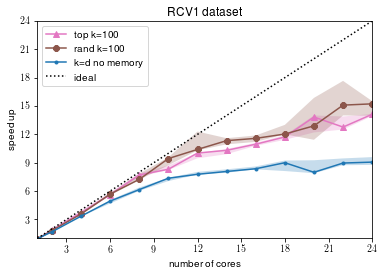

In [33]:
def speedup_rcv1(ax):
    data = unpickle_dir('../results/rcv-par/')
    speed_ups = compute_speedup_margin(data['chronos'])
    
    # markers_every = 10
    show = {
        "hogwild": ("C0.-", 'k=d no memory'),
        "rand100": ("C58-", "rand k=100"),
        "top100": ("C6^-", 'top k=100'),
    }

    for i, (p, speed_up) in enumerate(zip(data['models'], speed_ups)):
    #     ax.plot(data['cores'], speed_up, label=p.name)
        if p.name in show:
            style, label = show[p.name]
            num_values = (~np.isnan(speed_up)).sum(axis=-1)
            start = (num_values - 3) // 2
            n_cores = len(data['cores'])

            ax.plot(data['cores'], np.nanmedian(speed_up, axis=-1), style, label=label) # , markevery=markers_every
            ax.fill_between(data['cores'], speed_up[np.array(range(n_cores)), start], speed_up[np.array(range(n_cores)), start + 2], facecolor=style[:2], alpha=0.25)
#             ax.fill_between(data['cores'], np.nanmin(speed_up, axis=-1), np.nanmax(speed_up, axis=-1), facecolor=style[:2], alpha=0.25)


    ax.plot([1, 24], [1, 24], color='black', linestyle=':', label='ideal')
    ax.legend()
    ax.set_xlim([1,24])
    ax.set_ylim([1,24])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title('RCV1 dataset');
    ax.set_xlabel('number of cores');
    ax.set_ylabel('speed up');
    
fig, ax = plt.subplots(1)
speedup_rcv1(ax)

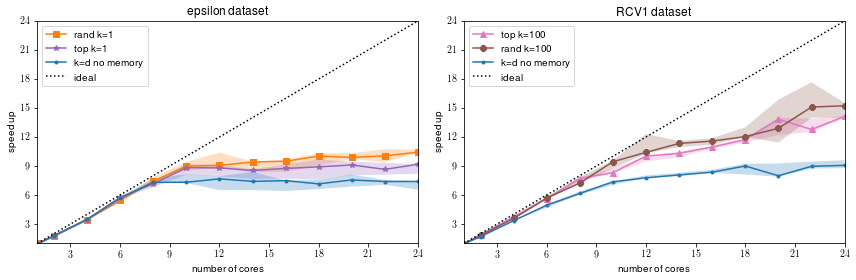

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax1, ax2 = axes

speedup_epsilon(ax1)
speedup_rcv1(ax2)
plt.tight_layout()
fig.savefig('../figures/speedup.pdf')